In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

In [2]:
heart_csv_path = 'C:/Users/Rawan Alamily/Downloads/McSCert Co-op/explainable-ai-heart/models/lifestyle-metrics-model/data/life-heart.csv'
dataframe = pd.read_csv(heart_csv_path)
print(dataframe.describe())
print(dataframe.shape)
dataframe['target'] = np.where(dataframe['heartDisease']=='Yes', 1, 0)
dataframe = dataframe.drop(columns=['heartDisease'])
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

                 bmi  physicalHealth   mentalHealth     sleepHours
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000
(319795, 17)


In [3]:
# function to build data pipeline to extract, shuffle and batch load the data
def df_to_dataset(df, batch_size=32):
    df = df.copy()
    labels = df.pop('target')
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    tf_dataset = tf_dataset.shuffle(buffer_size=len(df)) # shuffling values 
    tf_dataset = tf_dataset.batch(batch_size) # 32 samples per batch
    return tf_dataset.prefetch(batch_size) # to overlap preprocessing in the pipeline 

In [4]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer

In [5]:
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [6]:
def get_normalization_layer(feature_name, dataset):
    # normalize numeric features
    normalizer = layers.Normalization(axis=None)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    normalizer.adapt(feature_ds)
    return normalizer
def get_category_encoding_layer(feature_name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    # extract feature from dataset
    feature_ds = dataset.map(lambda x, y: x[feature_name])
    # 'learn' all possible feature values, assign each an int index 
    index.adapt(feature_ds)
    # encode integer index
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    # multi-hot encode indeices - lambda function captures layers
    return lambda feature: encoder(index(feature))

In [7]:
# with true batch size
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)
# preprocess all features:
inputs = []
encoded_features =[]

# numerical
for header in ["bmi", "physicalHealth", "mentalHealth", 'sleepHours' ]:
    num_col = tf.keras.Input(shape=(1,), name=header)
    # keras inputs array
    inputs.append(num_col)

    norm_layer = get_normalization_layer(feature_name=header, dataset=train_ds)
    encoded_num_col = norm_layer(num_col)
    # encoded feature
    encoded_features.append(encoded_num_col)

# categorical
for header in ["smoking","alcoholDrinking","stroke","diffWalk",
                "sex", "ageGroup", "diabetic", "physicalActivity", 
                "overallHealth", "asthma", "kidneyDisease", "skinCancer"]:
    cat_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # keras inputs array
    inputs.append(cat_col)

    cat_layer = get_category_encoding_layer(feature_name=header,
                                            dataset=train_ds, 
                                            dtype='string', 
                                            max_tokens=None)
    encoded_cat_col = cat_layer(cat_col)
    # encoded feature
    encoded_features.append(encoded_cat_col)

In [8]:
# merge list feature inputs into one vector
features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(units=128, activation="relu")(features)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, output)

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

result = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=5,
                    use_multiprocessing=True, verbose=2)

predictions = model.predict(test_ds)
binary_predictions = tf.round(predictions).numpy().flatten()

Epoch 1/5
7995/7995 - 27s - loss: 0.2309 - accuracy: 0.9153 - val_loss: 0.2222 - val_accuracy: 0.9174 - 27s/epoch - 3ms/step
Epoch 2/5
7995/7995 - 24s - loss: 0.2281 - accuracy: 0.9157 - val_loss: 0.2222 - val_accuracy: 0.9172 - 24s/epoch - 3ms/step
Epoch 3/5
7995/7995 - 31s - loss: 0.2273 - accuracy: 0.9159 - val_loss: 0.2221 - val_accuracy: 0.9172 - 31s/epoch - 4ms/step
Epoch 4/5
7995/7995 - 35s - loss: 0.2270 - accuracy: 0.9159 - val_loss: 0.2222 - val_accuracy: 0.9167 - 35s/epoch - 4ms/step
Epoch 5/5
7995/7995 - 32s - loss: 0.2265 - accuracy: 0.9158 - val_loss: 0.2225 - val_accuracy: 0.9170 - 32s/epoch - 4ms/step
1000/1000 [==============================] - 3s 2ms/step


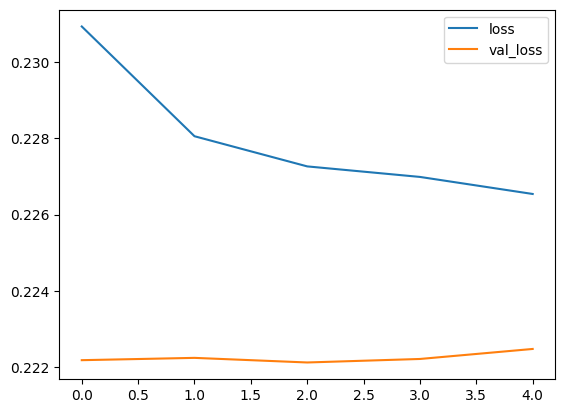

In [10]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

In [11]:
print(classification_report(test.get('target'), binary_predictions))
#print("f1 score: "+f1_)
# layer connectivity visualization
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     29200
           1       0.08      0.01      0.02      2780

    accuracy                           0.90     31980
   macro avg       0.50      0.50      0.48     31980
weighted avg       0.84      0.90      0.87     31980

